# Практическая работа №4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


In [2]:
# !pip install scikit-uplift==0.2.0

In [3]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

In [4]:
df = pd.read_csv('data.csv', ',')
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [5]:
df['treatment'] = df['offer'].apply(lambda x: 0 if x == 'No Offer' else 1)
df['target'] = df['conversion']
df.drop(['offer', 'conversion'], axis=1, inplace=True)
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [6]:
treatment = 'treatment'
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel'] 
target = 'target'
X_train, X_test, y_train, y_test = train_test_split(df[features + [treatment]], df[target], test_size=0.3, random_state=123)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [7]:
cat_features = ['used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']

models_results = {
    'approach': [],
    'uplift@30%': []
}

**Одна модель с признаком коммуникации**

uplift@30%: 0.0809


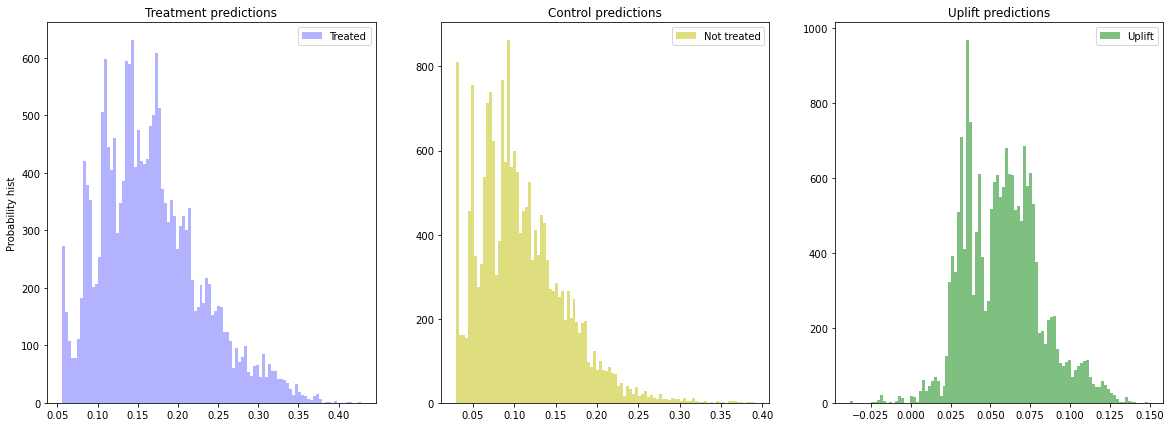

In [8]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train[features], y_train, X_train[treatment], estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test[features])

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test[treatment], strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [9]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,19.328608
1,is_referral,16.425977
2,used_bogo,13.735326
3,recency,11.923995
4,zip_code,11.369647
5,channel,10.506821
6,used_discount,9.622204
7,history,7.087422


**Трансформация классов**

In [10]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train[features], y_train, X_train[treatment], estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test[features])

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test[treatment], strategy='by_group', k=0.3)
print(f'uplift@30%: {ct_score:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-10-bcf797e670db>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train[features], y_train, X_train[treatment], estimator_fit_params={'cat_features': cat_features})


uplift@30%: 0.0812


**Две независимые модели**

uplift@30%: 0.0741


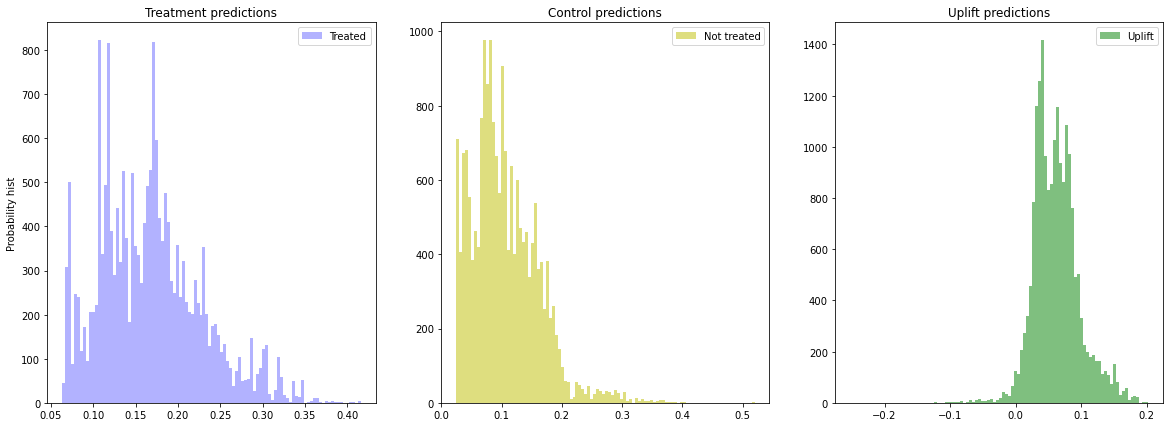

In [11]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train[features], y_train, X_train[treatment],
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test[features])

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test[treatment], strategy='by_group', k=0.3)
print(f'uplift@30%: {tm_score:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [12]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.081182
0,SoloModel,0.080899
2,TwoModels,0.074118
